In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

### EM for Mixture of Bivariate Normals

we're going to work with bivariates, so that's where the P-parameter controls is that we are bivariate normals. Again, we're going to work with three components in the mixture and we are going to have the same epsilon parameter that controls when to stop the algorithm. 

In [2]:
### Example of an EM algorithm for fitting a location mixture of 2 Gaussian components
### The algorithm is tested using simulated data

from scipy.stats import norm
from scipy.stats import multivariate_normal

## Clear the environment and load required libraries
np.random.seed(0)

## Generate data from a mixture with 2 components
p          = 2 # Bivariate normals
KK         = 3 # Number of componentes
w_true     = np.array([0.5, 0.3, 0.2])  # True weights associated with the components

mu_true    = np.zeros((KK, p)) # Matriz of true means
mu_true[0] = [0, 0] # True mean for the first component
mu_true[1] = [5, 5] # True mean for the second component
mu_true[2] = [-3, 7] # True mean for the third component

sigma_true = np.zeros((KK, p, p))   # Matriz of true covariance matrices
sigma_true[0] = np.array([[1, 0], [0, 1]])   # Covariance matrix of first component
sigma_true[1] = np.array([[2, 0.9], [0.9, 1]])   # Covariance matrix of second component
sigma_true[2] = np.array([[1, -0.9], [-0.9, 4]])   # Covariance matrix of third component

n          = 120         # Number of observations to be generated

### Step 1 ### Sample component indicators
cc    = np.random.choice([0, 1, 2], n, p = w_true) # C_i sample 
x     = []
### Step 2 ### Sample from normal distribution
for i in range(n):
  x.append(multivariate_normal.rvs(mean = mu_true[cc[i]], cov = sigma_true[cc[i]], size = 1))

x = np.array(x)
print('The first five samples of C_i are: {}'.format(cc[:5]))
print('The first five samples of the mixture are: \n{}'.format(x[:5]))

The first five samples of C_i are: [1 1 1 1 0]
The first five samples of the mixture are: 
[[ 4.36442604  6.04723685]
 [ 4.68620826  5.13527039]
 [ 2.88742341  2.68439491]
 [ 6.40435818  6.59778308]
 [-1.17312341  1.94362119]]


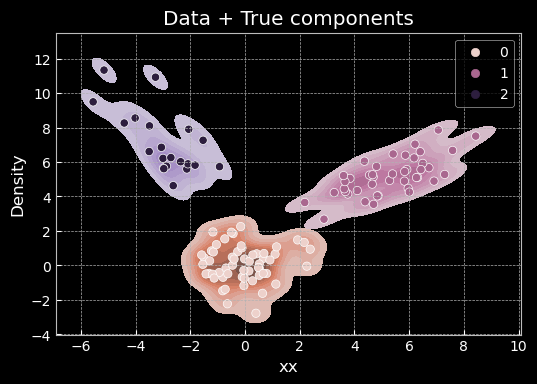

In [3]:
### Plotting the true distributions

# Plot f(x) along with the observations just sampled
sns.kdeplot(x[:, 0], x[:, 1], bw_method = .4, hue = cc, fill = True)
sns.scatterplot(x[:, 0], x[:, 1], hue = cc)
plt.xlabel('xx')
plt.ylabel('Density')
plt.title('Data + True components')
plt.legend()
plt.show()

### EM algorithm

The initial guess for w are: 
[0.33333333 0.33333333 0.33333333]
The initial guess for mu are: 
[[ 5.34344983  8.01364371]
 [ 0.17828835  8.38357575]
 [-0.86430113 -0.29487313]]
The initial guess for sigma are: 
[[[3.66397944 0.68055918]
  [0.68055918 3.35317368]]

 [[3.66397944 0.68055918]
  [0.68055918 3.35317368]]

 [[3.66397944 0.68055918]
  [0.68055918 3.35317368]]]


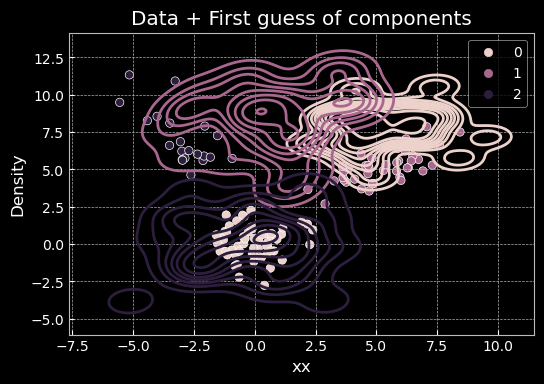

In [4]:
## Initialize the parameters
w     = np.ones(KK) / KK                         # Assign equal weight to each component to start with
mu    = multivariate_normal.rvs(mean = np.mean(x, axis = 0), cov = np.cov(x.T), size = KK)   # np.array([2.95, -0.996]) Random cluster centers randomly spread over the support of the data
Sigma = np.zeros((KK, p, p))   # Initial covariance mat deviation
Sigma[0] = np.cov(x.T) / KK   # Covariance matrix of first component
Sigma[1] = np.cov(x.T) / KK   # Covariance matrix of second component
Sigma[2] = np.cov(x.T) / KK   # Covariance matrix of third component

print('The initial guess for w are: \n{}'.format(w))
print('The initial guess for mu are: \n{}'.format(mu))
print('The initial guess for sigma are: \n{}'.format(Sigma))

# Sampling to visualize first guess
### Step 1 ### Sample component indicators
cc_test    = np.random.choice([0, 1, 2], n, p = w) # C_i sample 
xx     = []
### Step 2 ### Sample from normal distribution
for i in range(n):
  xx.append(multivariate_normal.rvs(mean = mu[cc_test[i]], cov = Sigma[cc_test[i]], size = 1))

xx = np.array(xx)

# Plotting first guess
sns.kdeplot(xx[:, 0], xx[:, 1], bw_method = .4, hue = cc_test, fill = False)
sns.scatterplot(x[:, 0], x[:, 1], hue = cc)
plt.xlabel('xx')
plt.ylabel('Density')
plt.title('Data + First guess of components')
plt.legend()
plt.show()

Mu values 
[[ 5.39520205  5.28049573]
 [-2.73709293  6.99319023]
 [ 0.01603303  0.22964129]]
Sigma values 
[[[ 64.92974869  32.51024202]
  [ 32.51024202  40.56808582]]

 [[ 60.44520716 -39.57941895]
  [-39.57941895  70.62194279]]

 [[  1.25511289   0.34733372]
  [  0.34733372   1.4352544 ]]]
Weight values 
[0.32756546 0.17991146 0.49252308]
The iteration 1 has a Q value of -649.7693858334172


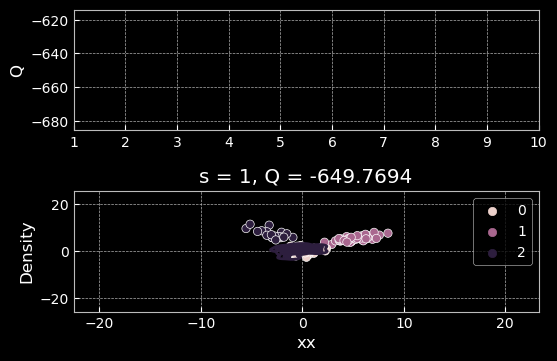

Mu values 
[[ 3.59894621  5.21836849]
 [-0.165381    6.25810131]
 [-0.06474573  0.14427296]]
Sigma values 
[[[ 5.29536849e+02  4.15464503e+00]
  [ 4.15464503e+00  1.31273268e+02]]

 [[ 3.42744880e+02 -1.09587423e+02]
  [-1.09587423e+02  1.23336718e+02]]

 [[ 9.80519874e-01  1.50849449e-01]
  [ 1.50849449e-01  1.07037868e+00]]]
Weight values 
[0.37258566 0.17438477 0.45302958]
The iteration 2 has a Q value of -758.5544343520512


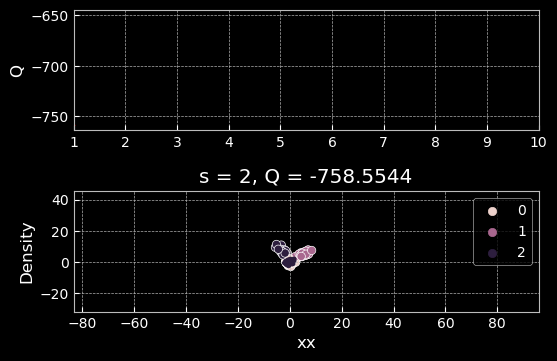

Mu values 
[[ 2.55398073  5.69082619]
 [ 2.36025167  5.73998975]
 [-0.0737539   0.13043799]]
Sigma values 
[[[ 6.19296889e+02 -1.05101061e+02]
  [-1.05101061e+02  1.21594169e+02]]

 [[ 4.40146905e+02 -8.24555008e+01]
  [-8.24555008e+01  8.61975727e+01]]

 [[ 9.62264956e-01  1.03481147e-01]
  [ 1.03481147e-01  1.04917140e+00]]]
Weight values 
[0.31420995 0.21809218 0.46769786]
The iteration 3 has a Q value of -748.8897253794806


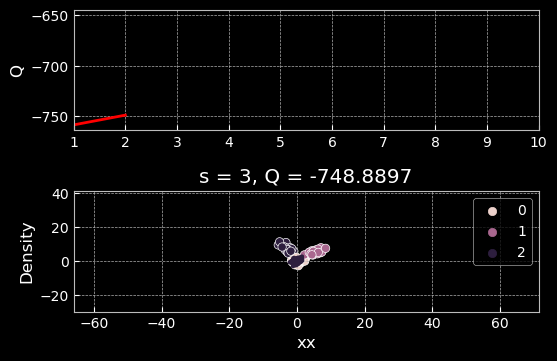

Mu values 
[[ 2.47208141  5.71570009]
 [ 2.48511936  5.71566826]
 [-0.07932837  0.12270366]]
Sigma values 
[[[ 5.34610359e+02 -9.55056305e+01]
  [-9.55056305e+01  1.04578771e+02]]

 [[ 5.24750708e+02 -9.38086860e+01]
  [-9.38086860e+01  9.96397240e+01]]

 [[ 9.48724084e-01  8.73757551e-02]
  [ 8.73757551e-02  1.04075790e+00]]]
Weight values 
[0.26816849 0.26433166 0.46749985]
The iteration 4 has a Q value of -747.695781088215


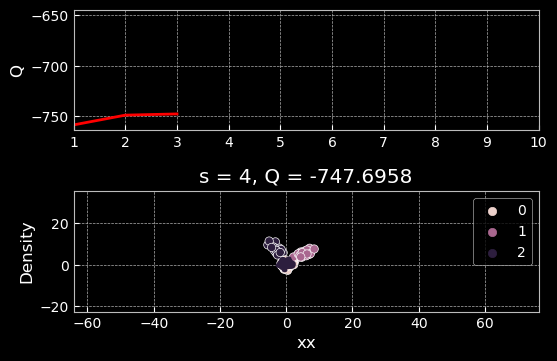

Mu values 
[[ 2.47709877  5.71175098]
 [ 2.47957767  5.71190146]
 [-0.08231832  0.12006523]]
Sigma values 
[[[ 5.24265268e+02 -9.36698980e+01]
  [-9.36698980e+01  1.01750009e+02]]

 [[ 5.35149127e+02 -9.55762573e+01]
  [-9.55762573e+01  1.03394233e+02]]

 [[ 9.41947039e-01  8.08023687e-02]
  [ 8.08023687e-02  1.03539659e+00]]]
Weight values 
[0.26374147 0.2693466  0.46691193]
The iteration 5 has a Q value of -747.9135512665179


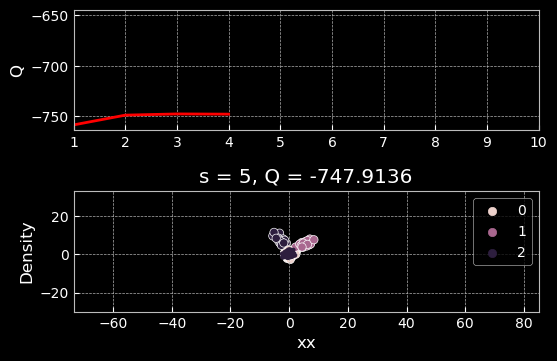

Mu values 
[[ 2.47886935  5.71022375]
 [ 2.47785068  5.71045674]
 [-0.08355399  0.11908517]]
Sigma values 
[[[ 5.28658182e+02 -9.44209464e+01]
  [-9.44209464e+01  1.02494836e+02]]

 [[ 5.30755797e+02 -9.48203980e+01]
  [-9.48203980e+01  1.03025725e+02]]

 [[ 9.39218601e-01  7.81945351e-02]
  [ 7.81945351e-02  1.03318831e+00]]]
Weight values 
[0.26616677 0.26714488 0.46668836]
The iteration 6 has a Q value of -747.9867273947051


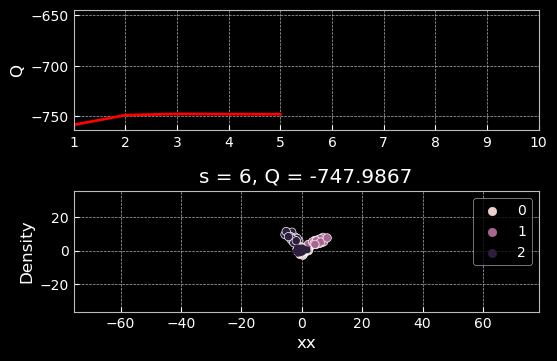

In [5]:
s  = 0     # Counter of the current iteration
sw = False # Decide when the algorithm will end
QQ = np.NINF  # Value of Q to monitor convergence
QQ_out = []
epsilon = 10e-5  # Stopping criteria

## Checking convergence of the algorithm
while(not sw):
  ## Expectation (E) step
  v = np.zeros((n, KK))
  for k in range(KK):
    v[:, k] = np.log(w[k]) + multivariate_normal.logpdf(mean = mu[k], cov = Sigma[k], x = x) # Compute the log of the weights
  for i in range(n):
    v[i, :] = np.exp(v[i, :] - max(v[i, : ])) / np.sum(np.exp(v[i, :] - max(v[i, :])))  # Go from logs to actual weights in a numerically stable manner

  ## Maximization (M) step
  # Weights
  w = np.mean(v, axis = 0)
  # Mus
  mu = np.zeros((KK, p))
  for k in range(KK):
    for i in range(n):
      # Update Mu
      mu[k, :] = mu[k, :] + (v[i, k] * x[i, :])
    mu[k, :] = mu[k, :] / np.sum(v[:, k])

  # Standard deviations
  Sigma = np.zeros((KK, p, p))
  for k in range(KK):
    for i in range(n):
      # Add new axis to operate properly
      Sigma[k, :, :] = Sigma[k, :, :] + (v[i,k] * np.dot((x[i, :] - mu[k, :])[:, np.newaxis], (x[i, :] - mu[k, :])[:, np.newaxis].T))
  Sigma[k, :, :] = Sigma[k, :, :] / np.sum(v[:, k])

  print('Mu values \n{}'.format(mu))
  print('Sigma values \n{}'.format(Sigma))
  print('Weight values \n{}'.format(w))

  ##Check convergence
  QQn = 0 # Value of Q function at current iteration
  for i in range(n):
    for k in range(KK):
      QQn = QQn + v[i, k] * (np.log(w[k]) + multivariate_normal.logpdf(mean = mu[k, :], cov = Sigma[k, :, :], x = x[i, :]))

  # If relative error is less than epsilon stop
  if(np.abs(QQn - QQ) / np.abs(QQn) < epsilon):
    sw = True
  QQ = QQn
  QQ_out.append(QQ)
  s = s + 1
  print('The iteration {} has a Q value of {}'.format(s, QQn))

  # Plotting Q value
  fig, axs = plt.subplots(2)
  axs[0].plot(QQ_out[0 : s], c = 'red')
  axs[0].set_ylabel('Q')
  axs[0].axis(xmin = 1, xmax = max(10, s))
  axs[1].set_title("Q-value over iterations")

  # Sampling to visualize current iteration
  ### Step 1 ### Sample component indicators
  cc_test    = np.random.choice([0, 1, 2], n, p = w) # C_i sample 
  xx     = []
  ### Step 2 ### Sample from normal distribution
  for i in range(n):
    xx.append(multivariate_normal.rvs(mean = mu[cc_test[i]], cov = Sigma[cc_test[i]], size = 1))

  xx = np.array(xx)

  # Plotting first guess
  axs[1] = sns.kdeplot(xx[:, 0], xx[:, 1], bw_method = .4, hue = cc_test, fill = False)
  axs[1] = sns.scatterplot(x[:, 0], x[:, 1], hue = cc)
  axs[1].set_xlabel('xx')
  axs[1].set_ylabel('Density')
  axs[1].set_title("s = {}, Q = {}".format(s, np.round(QQ_out[s - 1], 4)))
  fig.subplots_adjust(hspace=0.5)
  plt.legend()
  plt.show()

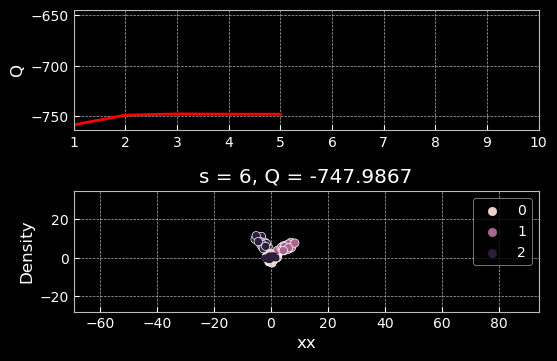

In [6]:
# Plotting Q value
fig, axs = plt.subplots(2)
axs[0].plot(QQ_out[0 : s], c = 'red')
axs[0].set_ylabel('Q')
axs[0].axis(xmin = 1, xmax = max(10, s))
axs[1].set_title("Q-value over iterations")

# Sampling to visualize current iteration
### Step 1 ### Sample component indicators
cc_test    = np.random.choice([0, 1, 2], n, p = w) # C_i sample 
xx     = []
### Step 2 ### Sample from normal distribution
for i in range(n):
  xx.append(multivariate_normal.rvs(mean = mu[cc_test[i]], cov = Sigma[cc_test[i]], size = 1))

xx = np.array(xx)

# Plotting first guess
axs[1] = sns.kdeplot(xx[:, 0], xx[:, 1], bw_method = .4, hue = cc_test, fill = False)
axs[1] = sns.scatterplot(x[:, 0], x[:, 1], hue = cc)
axs[1].set_xlabel('xx')
axs[1].set_ylabel('Density')
axs[1].set_title("s = {}, Q = {}".format(s, np.round(QQ_out[s - 1], 4)))
fig.subplots_adjust(hspace=0.5)
plt.legend()
plt.show()